## Credit Risk Classification

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_importance

## EDA

In [2]:
#read/open the dataset
path = r'..\data'

#the first column is the index
df = pd.read_csv(path + '\german_credit_data.csv', index_col='Unnamed: 0')

In [3]:
#overview of the dataset
df.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


The target variable is 'Risk', which is what we want to predict. It contains 2 unique values thus this is a binary classification problem.

In [4]:
#There are 1000 rows and 9 features in the dataset (exluding y)
df.shape

(1000, 10)

Descriptive statistics of the dataset. We can already see the presence of outliers in the dataset, which be elaborated later on.

In [5]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


There is an interesting observation we can make by looking at the below information. There are
twice as many men than women who have applied and received credit. Moreover men tend to apply and receive credit a later stage of their lives.

In [6]:
#distribution between men and women
print('Distibution based on gender:\n' + str(df['Sex'].value_counts()), '\n')
print(df.groupby('Sex')['Age'].mean())

Distibution based on gender:
male      690
female    310
Name: Sex, dtype: int64 

Sex
female    32.803226
male      36.778261
Name: Age, dtype: float64


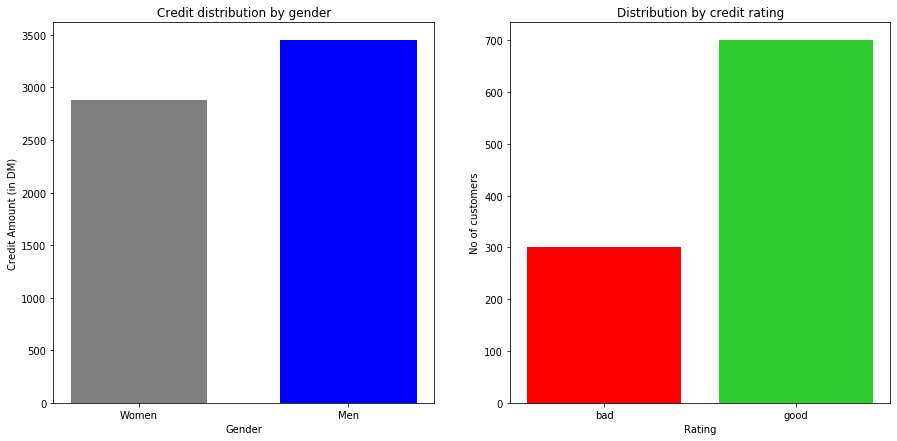

In [7]:
#preparing the data for the barplot
list1 = [i for i in df.groupby('Sex')['Credit amount'].mean()]
labels = ['Women', 'Men']
colors = ['gray', 'b', 'r', 'limegreen']
no_risk = []
no_risk.extend([df['Risk'].value_counts()[1], df['Risk'].value_counts()[0]])
risk_names = np.unique(df['Risk'].values)

#barplot showing the average credit amount that each gender receives
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].bar(labels, list1, color=colors[:2], width=0.65)
axs[0].set_ylabel('Credit Amount (in DM)')
axs[0].set_xlabel('Gender')
axs[0].set_title('Credit distribution by gender')

#second barplot
axs[1].bar(risk_names, no_risk, color=colors[2:])
axs[1].set_title('Distribution by credit rating')
axs[1].set_ylabel('No of customers')
axs[1].set_xlabel('Rating')
plt.show()

It is evident from the above barplot that men get an approximately **19%** higher credit amount than women. We can also observe that the dataset is *imbalanced* as there are more customers with a good credit rating than with bad (70% - 30%). We need to consider if we need to deploy an under/oversampling technique later on.

We now want to see the purpose that each customer applies and  receives credit for.

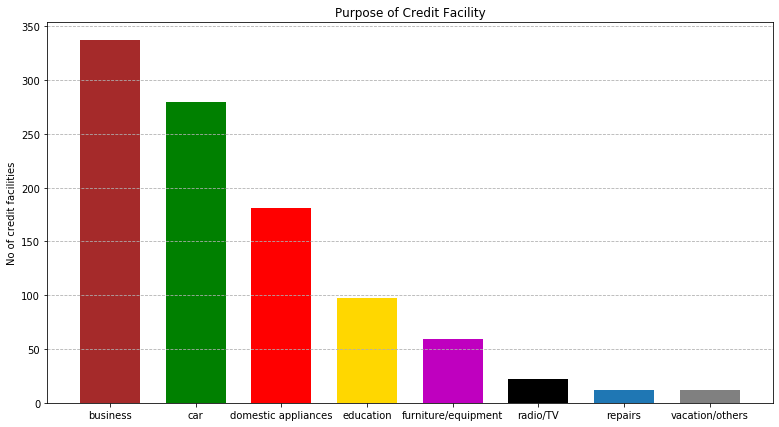

In [8]:
#preparing the data for the barplot
purpose = np.unique(df['Purpose'])
no_purpose = df['Purpose'].value_counts()
colors_1 = ['brown','g','r', 'gold', 'm', 'k', 'tab:blue', 'gray']

#Plot showing the reason for credit
plt.figure(figsize=(13,7))
plt.bar(purpose, no_purpose, color=colors_1, width=0.7)
plt.ylabel('No of credit facilities')
plt.title('Purpose of Credit Facility')
plt.grid(axis='y', linestyle='--')
plt.show()

Most customers, around 34%, receive credit for business purposes. Car loans are quite popular, as well as credit for house appliances. On the other hand, credit for holidays and repairs are rarely been given.


Let's have a look at the distribution of ages in the dataset. We are going to use a boxplot for this.

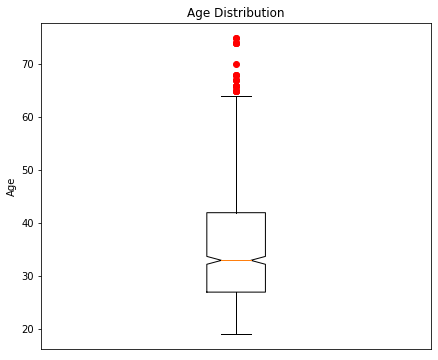

In [9]:
#boxplot
fig, ax1 = plt.subplots(figsize=(7,6))
ax1.boxplot(df['Age'], notch=True, sym='r')
ax1.set_title('Age Distribution')
ax1.set_xticks([])
ax1.set_ylabel('Age')
plt.show()

The median age is around the age of 33 and most customers who received credit are between ages 27 - 41. It is also evident that there are some outliers, specifically Ages above 63. <br>

We also want to visualize the probability distribution of the credit amount and duration period (in months) of each credit facility. This can be achieved by using **violin plots**.

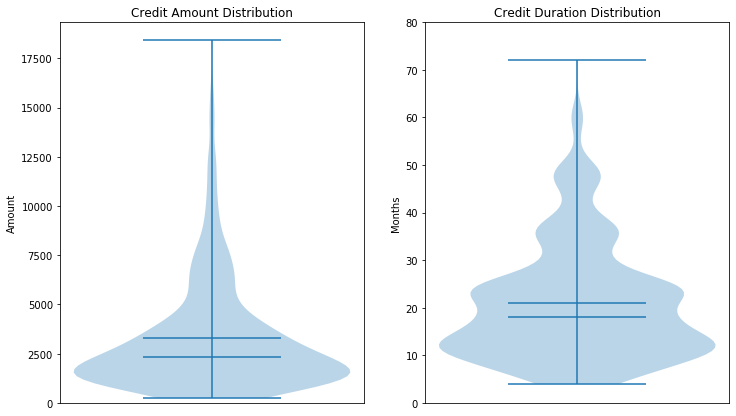

In [10]:
#setting max values
max_duration = np.max(df['Duration']) + 10
max_amount = np.max(df['Credit amount']) + 1000

#violin plots on credit amount and duration period of credit facility
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axs[0].violinplot(df['Credit amount'], showmeans=True, showextrema=True, showmedians=True)
axs[0].set_ylim(ymin=0)
axs[0].set_yticks(np.arange(0, max_amount, step=2500))
axs[0].set_ylabel('Amount')
axs[0].set_xticks([])
axs[0].set_title('Credit Amount Distribution')
#second violinplot
axs[1].violinplot(df['Duration'], showmeans=True, showextrema=True, showmedians=True)
axs[1].set_title('Credit Duration Distribution')
axs[1].set_yticks(np.arange(0, max_duration, step=10))
axs[1].set_xticks([])
axs[1].set_ylabel('Months')
plt.show()

Let's have a look at the relationship between risk and job. Firstly, the labels and the category they correspond to can be found below:

- 0 - unskilled and non-resident 
- 1 - unskilled and resident 
- 2 - skilled
- 3 - highly skilled

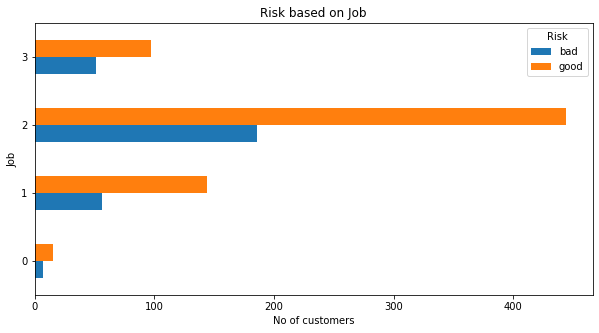

In [11]:
#preparing the data
job_risk = pd.crosstab(df['Job'],df['Risk'])
#horizontal barplot
job_risk.plot.barh(figsize=(10,5))
plt.title('Risk based on Job')
plt.xlabel('No of customers')
plt.show()

We can now look into the relationship between Housing and Risk. We want to identify what is the risk rating of customers based on their housing situation. Based on the plot, we can observe that customers who own their house are more likely to have a good credit rating.

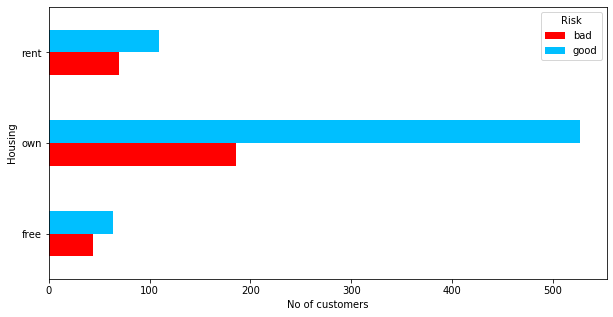

In [12]:
#preparing the data
house_risk = pd.crosstab(df['Housing'], df['Risk'])
#visualizing the data using a horizontal barplot
house_risk.plot.barh(figsize=(10,5), color=['r','deepskyblue'])
plt.xlabel('No of customers')
plt.show()

## Preprocessing

It is imperative to see whether there are any **missing values** in the dataset. We can easily check this by running the following code;

In [13]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

There are indeed missing values in 2 of the dataset's columns. At this point, we need to consider which imputation technique we will deploy to treat this issue. Running the following code we can also observe that in this case we are dealing with categorical variables. These will also need to be transformed into numerical values in order for the ML model to be able to process them.

In [14]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

We impute the categorical data by assigning them a different category, specifically **'other'**.

In [15]:
#imputation
df['Saving accounts'] = df['Saving accounts'].fillna('other')
df['Checking account'] = df['Checking account'].fillna('other')

Moving on by converting the categorical variables into numerical and consequently dropping the categorical columns.

In [16]:
#Purpose
df = df.merge(pd.get_dummies(df['Purpose'], prefix='Purpose'), left_index=True, right_index=True)
#Sex
df = df.merge(pd.get_dummies(df['Sex'], prefix='Sex'), left_index=True, right_index=True)
#Housing
df = df.merge(pd.get_dummies(df['Housing'], prefix='Housing'), left_index=True, right_index=True)
#Saving Accounts
df = df.merge(pd.get_dummies(df["Saving accounts"], prefix='Savings'), left_index=True, right_index=True)
#Checking Account
df = df.merge(pd.get_dummies(df["Checking account"], prefix='Check'), left_index=True, right_index=True)

#dropping the categorical columns
col_names = ['Sex', 'Purpose', 'Housing', 'Saving accounts', 'Checking account']

#function to drop the redundant columns
def drop_col(dataframe, names):
    for name in names:
        dataframe = dataframe.drop(columns=name)
    return dataframe

#using the function to the dataset
df = drop_col(df, col_names)

The next step involves scaling the data which is required step before feeding them into Kmeans. We will use the LabelEncoder to transform the target variable.

In [17]:
#seperating the target variable from the rest of the dataset
df_risk = df['Risk']
df_rest = df.drop('Risk', axis=1)

#Initializing the scaler
scaler = StandardScaler()
#fitting it into the data and subsequently transforming them
df_sc = scaler.fit_transform(df_rest)

#using label encoder to convert the target variable into numeric
le = LabelEncoder()
#fitting and transforming the target variable
df_risk = le.fit_transform(df_risk)

## Models

We set the y and X variables and we proceed by splitting the data. We also set a random state for reproducibility purposes.

In [18]:
#setting the y and X variables
y = df_risk
X = df_sc

We will make use of 3 different Machine Learning algorithms, specifically **Decision Tree, Logistic Regression** and **XGBoost**. The evaluation metric we will use is recall instead of accuracy. Remember that the formula for recall is: <br> 

$$ R = \frac{ TP }{TP + FP} $$ <br>

where TP = True Positive <br>
and FP = False Positive <br> <br>

In [20]:
random_state = 42
#initializing the ML models
dt = DecisionTreeClassifier(random_state=random_state)
lr = LogisticRegression(random_state=random_state)
xgb_cl = xgb.XGBClassifier(use_label_encoder=False, random_state=random_state)

#oversampling using SMOTE
sm = SMOTE()
scores = []
models = []
models.extend([dt, lr, xgb_cl])
kf = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
X_os, y_os = sm.fit_sample(X, y)

#splitting the data
for fold, (train_index, test_index) in enumerate(kf.split(X_os, y_os), 1):
    X_train_os = X_os[train_index]
    y_train_os = y_os[train_index]
    X_test_os = X_os[test_index]
    y_test_os = y_os[test_index]
    
for model in models:
    model.fit(X_train_os, y_train_os)  
    #note that we are using recall instead of accuracy
    cvs = cross_val_score(model, X_train_os, y_train_os, cv=kf, scoring='recall', verbose=0)
    scores.append(cvs)

[15:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:34:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

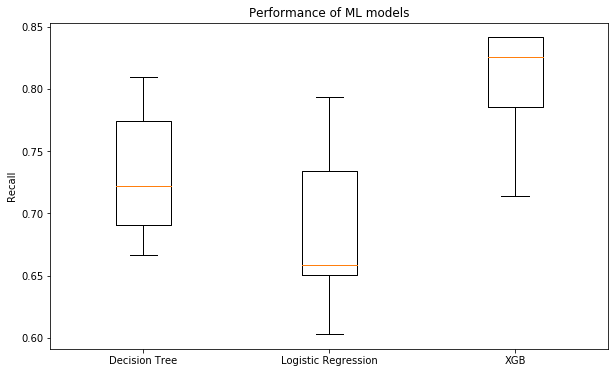

In [21]:
#checking the performance of the models with a simple boxplot
ml_alg = ['Decision Tree', 'Logistic Regression', 'XGB']
plt.figure(figsize=(10,6))
plt.boxplot(scores, labels=ml_alg)
plt.title('Performance of ML models')
plt.ylabel('Recall')
plt.show()

### XGBoost

Let's move ahead with **XGB** as it performs better than the other 2 algorithms. We will fine tune the parameters and then use them to improve the performance of the ML model.

In [22]:
#XGB
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              nthread=4, use_label_encoder=False,
                              eval_metric='error', random_state=random_state)
#setting the parameters
parameters = {'max_depth': range(3,10,2),
              'min_child_weight': range(1,6,2),
              'learning_rate': [0.1, 0.01, 0.05], 
              'n_estimators': list(range(100, 750, 50)),
              'max_depth': list(range(2, 12, 2))}

#grid search and fitting the model to the data
xgb_cv = GridSearchCV(estimator=xgb_model, param_grid=parameters, 
                           scoring='roc_auc', n_jobs=-1, cv=10,
                           verbose=0).fit(X_train_os, y_train_os)

#saving the best parameters
best_model = xgb_cv.best_params_
print(best_model)

#initializing the model using the best parameters and then fitting it into the data
xgb_tuned = xgb.XGBClassifier(**best_model, use_label_encoder=False, 
                              random_state=random_state).fit(X,y)
#predictions
y_pred = xgb_tuned.predict(X_test_os)
#cross validation
print(cross_val_score(xgb_tuned, X_os, y_os, cv = 10).mean())

{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150}
[16:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

In [23]:
#Evaluation metrics
print(classification_report(y_test_os, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86        70
           1       0.80      1.00      0.89        70

    accuracy                           0.88       140
   macro avg       0.90      0.88      0.88       140
weighted avg       0.90      0.88      0.88       140



The model achieves **88%** test accuracy. To evaluate the performance of this classification model and find out both the True Positive (recall) and False Positive Rate, we can have a look at the **ROC** (Receiver Operator Characteristic) curve below. Also note that the FPR is defined as follows;

$$ FPR = \frac{ FP }{FP + TN} $$ <br>

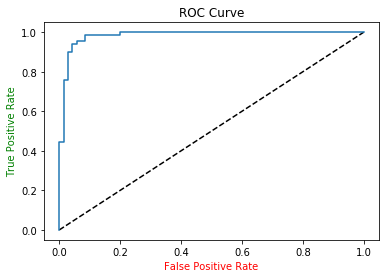

Area Under Curve: 0.98


In [37]:
#ROC curve values
y_pred_prob = xgb_tuned.predict_proba(X_test_os)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_os, y_pred_prob)

#ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
plt.show()
#AUC 
print (f"Area Under Curve: {round(auc(fpr, tpr),2)}")

**AUC** (Area under the ROC Curve) is 98%, which means that **98%** of all predictions are correct. Lastly, our findings suggest that the most important factors when it comes to risk in this classifier are *Credit Amount* and *Age*.

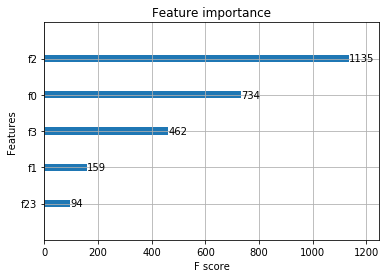

In [39]:
#plot of feature importance
plot_importance(xgb_tuned, max_num_features=5)
plt.show()